Producing Evidence Histogram:

The data used to simulate the QPO lightcurves.

|Parameter      |    $K_{rn}$ values   |    $K_{qpo + rn}$ values   |
|:--------------|:--------------------:|:--------------------------:|
|$a_{rn}$       |  exp(1)              |  exp(1)                    |
|$c_{rn}$       |  exp(1) $s^{-1}$     |  exp(1) $s^{-1}$           |
|$a_{qpo}$      |      -               |  exp(-2) or exp(-0.4)      |
|$c_{qpo}$      |      -               |  exp(1) $s^{-1}$           |
|$f_{qpo}$      |      -               |      20 Hz                 |
|A              |      3               |      3                     |
|$t_{0}$        |      0.5 s           |      0.5 s                 |
|$\sigma$       |      0.2 s           |      0.2 s                 |

We will simulate lightcurves and anlyse the evidences produced

In [1]:
# Dependancies

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import tinygp
from tinygp import GaussianProcess, kernels
from stingray import Lightcurve
jax.config.update("jax_enable_x64", True)

import functools

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [2]:
# Mean Model

def gaussian(t, mean_params):
    return mean_params["A"] * jnp.exp(-((t - mean_params["t0"])**2)/(2*(mean_params["sig"]**2)))

# Build Gp
def build_gp(kernel_params, mean_params, t, kernel_type, mean_type = "gaussian"):
    if kernel_type == "QPO_plus_RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5) + kernels.quasisep.Celerite(
                a = kernel_params["aqpo"], b = 0.0, c = kernel_params["cqpo"], d = 2*jnp.pi*kernel_params["freq"])
    elif kernel_type == "RN":
        kernel = kernels.quasisep.Exp(
                scale = 1/kernel_params["crn"], sigma = (kernel_params["arn"])**0.5)
    
    # Using partial to make the mean so that it only takes the time value
    if mean_type == "gaussian":
        mean = functools.partial(gaussian, mean_params = mean_params)
        return tinygp.GaussianProcess( kernel, t, mean=mean)
    elif mean_type == "constant":
        mean = mean_params
        return tinygp.GaussianProcess( kernel, t)

In [3]:
# Parameters, kernels for RN, lqpo_rn, hqpo_rn

rnparams = {
    "arn": jnp.exp(1.0),    "crn": jnp.exp(1.0),
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}

rnkernel = kernels.quasisep.Exp(
                scale = 1/rnparams["crn"], sigma = (rnparams["arn"])**0.5)

lqpoparams = {
    "arn" : jnp.exp(1.0),   "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-2),   "cqpo": jnp.exp(1),    "freq": 20
}

lqpokernel = kernels.quasisep.Exp(
    scale = 1/lqpoparams["crn"], sigma = (lqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = lqpoparams["aqpo"], b = 0.0, c = lqpoparams["cqpo"], d = 2*jnp.pi*lqpoparams["freq"])

hqpoparams = {
    "arn" : jnp.exp(1.0),    "crn" : jnp.exp(1.0),
    "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,
}

hqpokernel = kernels.quasisep.Exp(
    scale = 1/hqpoparams["crn"], sigma = (hqpoparams["arn"])**0.5) + kernels.quasisep.Celerite(
        a = hqpoparams["aqpo"], b = 0.0, c = hqpoparams["cqpo"], d = 2*jnp.pi*hqpoparams["freq"])


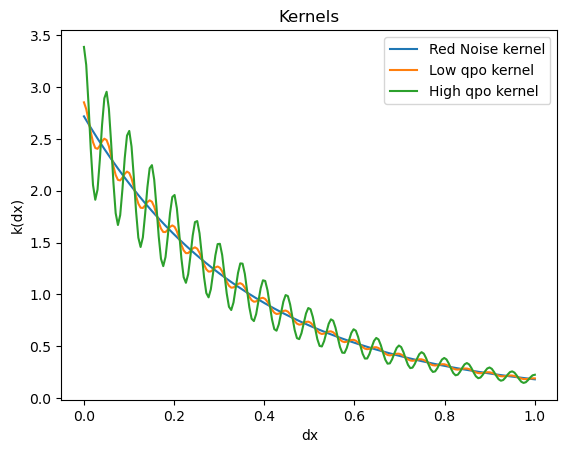

In [4]:
def plot_kernel(kernel, **kwargs):
    """ A function to plot the kernel"""
    dx = np.linspace(0, 1, 200)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    # print(kernel(dx, dx[:1]))
    plt.xlabel("dx")
    plt.legend()
    plt.title("Kernels")
    plt.ylabel("k(dx)")

plot_kernel(rnkernel, label="Red Noise kernel")
plot_kernel(lqpokernel, label="Low qpo kernel")
plot_kernel(hqpokernel, label="High qpo kernel")

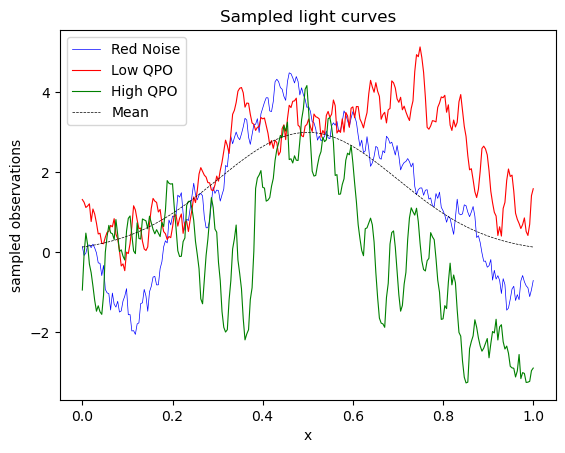

In [11]:
Times = np.linspace(0,1,256)  # 1 secound lightcurve with 256 points

mean_params = {
    "A" : 3,    "t0" : 0.5,    "sig" : 0.2,
}

rngp = build_gp(rnparams, mean_params, Times, kernel_type = "RN")
lqpogp = build_gp(lqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN")
hqpogp = build_gp(hqpoparams, mean_params, Times, kernel_type = "QPO_plus_RN")

rngp_sample   =  rngp.sample( jax.random.PRNGKey(11), shape=(1,))
lqpogp_sample = lqpogp.sample(jax.random.PRNGKey(12), shape=(1,))
hqpogp_sample = hqpogp.sample(jax.random.PRNGKey(13), shape=(1,))

plt.plot(Times, rngp_sample.T, lw=0.5,color = "b" ,label = "Red Noise")
plt.plot(Times, lqpogp_sample.T, lw=0.8, color = "r", label = "Low QPO")
plt.plot(Times, hqpogp_sample.T, lw=0.8, color = "g", label = "High QPO")
plt.plot(Times, rngp.mean_function(Times), color = "k", lw=0.5, ls = "--", label = "Mean")
plt.xlabel("x")
plt.ylabel("sampled observations")
plt.legend()
_ = plt.title("Sampled light curves")

In [9]:
# Calculating evidences using jaxns
# Loading dependencies

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import ExactNestedSampler
from jaxns import TerminationCondition
from jaxns import analytic_log_evidence
from jaxns import Prior, Model

tfpd = tfp.distributions

In [22]:
lightcurve = hqpogp.sample(jax.random.PRNGKey(4))
T = Times[-1] - Times[0]
print(T)
f = 1/(Times[1] - Times[0])
print(f)
print((2/T, f/2))
print(jnp.log(1/T), jnp.log(f))
print(1/10/T, jnp.log(f))
min = jnp.min(lightcurve)
max = jnp.max(lightcurve)
print(min, max)
span = max - min
print(0.1*span, 2*span)
print(Times[0]-0.1*T, Times[-1]+0.1*T)
print(0.5*1/f, 2*T)

1.0
255.0
(2.0, 127.5)
0.0 5.541263545158426
0.1 5.541263545158426
-2.7288885484254113 5.377110202125852
0.8105998750551264 16.211997501102527
-0.1 1.1
0.00196078431372549 2.0


In [60]:
from tqdm import tqdm
from jax import jit

def get_evidences(Times, lightcurve):
    results = {}
    def RNprior_model():
        T = Times[-1] - Times[0]    # Total time
        f = 1/(Times[1] - Times[0]) # Sampling frequency
        min = jnp.min(lightcurve)
        max = jnp.max(lightcurve)
        span = max - min

        arn = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='arn') 
        crn = yield Prior(tfpd.Uniform(jnp.log(1/T), jnp.log(f)), name='crn')

        A = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='A') 
        t0 = yield Prior(tfpd.Uniform(Times[0]-0.1*T, Times[-1]+0.1*T), name='t0')
        sig = yield Prior(tfpd.Uniform(0.5*1/f, 2*T), name='sig')
        return arn, crn, A, t0, sig

    def QPOprior_model():
        T = Times[-1] - Times[0]    # Total time
        f = 1/(Times[1] - Times[0]) # Sampling frequency
        min = jnp.min(lightcurve)
        max = jnp.max(lightcurve)
        span = max - min
        
        arn = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='arn')
        crn = yield Prior(tfpd.Uniform(jnp.log(1/T), jnp.log(f)), name='crn')
        aqpo = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='aqpo')
        cqpo = yield Prior(tfpd.Uniform(1/10/T, jnp.log(f)), name='cqpo')
        freq = yield Prior(tfpd.Uniform(2/T, f/2 ), name='freq')

        A = yield Prior(tfpd.Uniform(0.1*span, 2*span), name='A')
        t0 = yield Prior(tfpd.Uniform(Times[0]-0.1*T, Times[-1]+0.1*T), name='t0')
        sig = yield Prior(tfpd.Uniform(0.5*1/f, 2*T), name='sig')

        return arn, crn, aqpo, cqpo, freq, A, t0, sig

    @jit     
    def RNlog_likelihood2(arn, crn, A, t0, sig):
        rnlikelihood_params = {"arn": arn, "crn": crn,
                            "aqpo": 0.0, "cqpo": 0.0, "freq": 0.0, }
                
        mean_params = { "A": A, "t0": t0, "sig": sig, }
                
        gp = build_gp(rnlikelihood_params, mean_params, Times, kernel_type = "RN")
        return gp.log_probability(lightcurve)

    @jit
    def QPOlog_likelihood2(arn, crn, aqpo, cqpo, freq,  A, t0, sig):
        qpolikelihood_params = {"arn": arn, "crn": crn,
                                "aqpo": aqpo, "cqpo": cqpo, "freq": freq, }
                
        mean_params = {"A": A, "t0": t0, "sig": sig,}
                
        gp = build_gp(qpolikelihood_params, mean_params, Times, kernel_type = "QPO_plus_RN")
                
        return gp.log_probability(lightcurve)
            
    RNmodel = Model(prior_model= RNprior_model, log_likelihood=RNlog_likelihood2)
    RNexact_ns = ExactNestedSampler(RNmodel, num_live_points= 500, max_samples= 1e4)
    RNtermination_reason, RNstate = RNexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
    RNresults = RNexact_ns.to_results(RNstate, RNtermination_reason)
    results["RNexact_ns"] = RNexact_ns
    results["RNresults"] = RNresults
    # print(RNresults.log_Z_mean)

    QPOmodel = Model(prior_model= QPOprior_model, log_likelihood=QPOlog_likelihood2)
    QPOexact_ns = ExactNestedSampler(QPOmodel, num_live_points= 500, max_samples= 1e4)
    QPOtermination_reason, QPOstate = QPOexact_ns(random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4))
    QPOresults = QPOexact_ns.to_results(QPOstate, QPOtermination_reason)
    results["QPOexact_ns"] = QPOexact_ns
    results["QPOresults"] = QPOresults
    # print(QPOresults.log_Z_mean)

    return results

def make_evidence_histogram(n = 1):
    BFrn = np.zeros(n)
    BFlqpo = np.zeros(n)
    BFhqpo = np.zeros(n)

    for i in tqdm(range(n)):
        rngp_sample   = rngp.sample(jax.random.PRNGKey(i*i))
        lqpogp_sample = lqpogp.sample(jax.random.PRNGKey(i*i))
        hqpogp_sample = hqpogp.sample(jax.random.PRNGKey(i*i))
        rn_result = get_evidences(Times, rngp_sample)
        BFrn[i] = rn_result["QPOresults"].log_Z_mean - rn_result["RNresults"].log_Z_mean
        lqpo_result = get_evidences(Times, lqpogp_sample)
        BFlqpo[i] = lqpo_result["QPOresults"].log_Z_mean - lqpo_result["RNresults"].log_Z_mean
        hqpo_result = get_evidences(Times, hqpogp_sample)
        BFhqpo[i] = hqpo_result["QPOresults"].log_Z_mean - hqpo_result["RNresults"].log_Z_mean

    return BFrn, BFlqpo, BFhqpo

In [79]:
lightcurve = hqpogp.sample(jax.random.PRNGKey(4))
Results = get_evidences(Times, lightcurve)

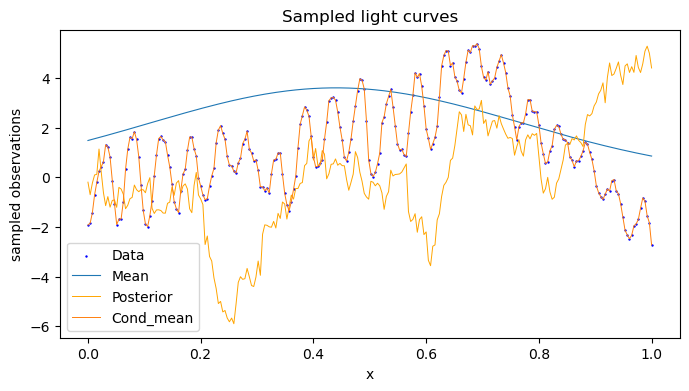

In [80]:
# Plot the lightcurve and the expected model conditioned on the data
# Problem, getting the mean or the max prior value after sampling

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(Times, lightcurve.T, lw=0.7, color = "b", label = "Data", s = 1)

post_rnparams = {
    "arn": 9.6,    "crn": 3.74,
    "aqpo": 0.0,    "cqpo": 0.0,    "freq": 0.0
}
post_rnmeanparams = {
    "A": 3.6,    "t0": 0.44,    "sig": 0.33
}

gp = build_gp(post_rnparams, post_rnmeanparams, Times, kernel_type = "RN")
_ , cond_gp = gp.condition(lightcurve)
ax.plot(Times, gp.mean, lw=0.8, label = "Mean") 
ax.plot(Times, gp.sample(jax.random.PRNGKey(10), shape=(1,)).T, lw=0.7, c = "orange", label = "Posterior")
ax.plot(Times, cond_gp.mean, lw = 0.7, label = "Cond_mean")
ax.set_xlabel("x")
ax.set_ylabel("sampled observations")
ax.legend()
_ = plt.title("Sampled light curves")

In [81]:
Results["RNexact_ns"].summary(Results["RNresults"])

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 379022
# samples: 9652
# slices: 88000.0
# slices / acceptance: 11.0
# likelihood evals / sample: 39.3
# likelihood evals / slice: 4.3
--------
logZ=-193.88 +- 0.11
H=190.0
ESS=2390
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 2.8 +- 1.5 | 1.3 / 2.6 / 4.3 | 3.4 | 3.4
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 8.4 +- 2.9 | 6.1 / 6.6 / 13.4 | 6.0 | 6.0
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 4.3 +- 1.1 | 2.5 / 4.9 / 5.2 | 5.3 | 5.3
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 0.43 +- 0.59 | 0.01 / 0.09 / 1.5 | 0.01 | 0.01
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.49 +- 0.23 | 0.16 / 0.48 / 0.78 | 0.48 | 0.48
--------


WARNING[2023-06-07 01:49:23,064]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


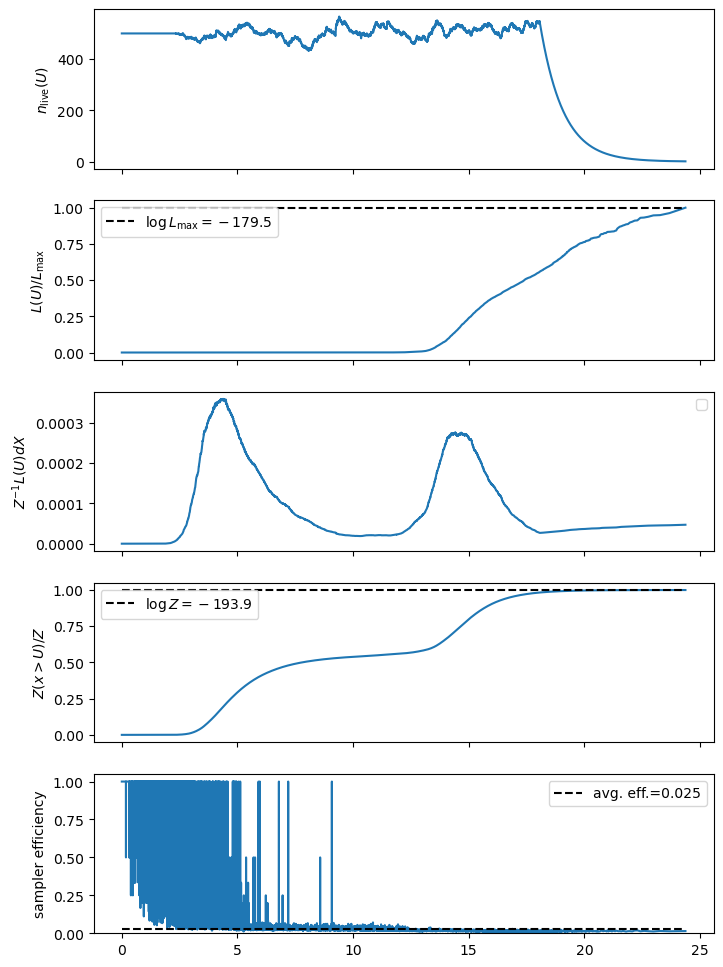

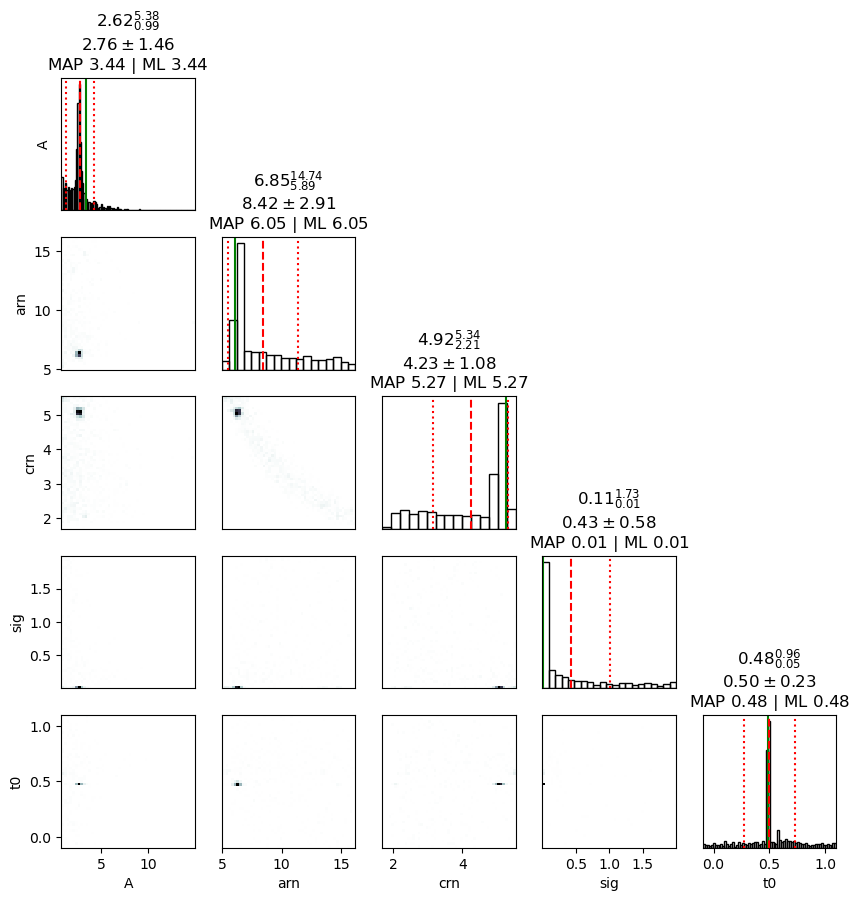

In [82]:
Results["RNexact_ns"].plot_diagnostics(Results["RNresults"])
Results["RNexact_ns"].plot_cornerplot(Results["RNresults"])

In [83]:
Results["QPOexact_ns"].summary(Results["QPOresults"])

--------
Termination Conditions:
Reached max samples
Small remaining evidence
--------
# likelihood evals: 2764239
# samples: 10000
# slices: 676188.0
# slices / acceptance: 81.0
# likelihood evals / sample: 276.4
# likelihood evals / slice: 4.1
--------
logZ=-61.96 +- 0.16
H=62.0
ESS=916
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 3.8 +- 1.2 | 2.2 / 3.7 / 5.2 | 3.5 | 3.5
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 2.5 +- 2.0 | 0.9 / 1.9 / 4.1 | 1.7 | 1.7
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 7.1 +- 2.1 | 4.5 / 7.1 / 9.6 | 5.7 | 5.7
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 0.51 +- 0.42 | 0.14 / 0.35 / 1.08 | 0.33 | 0.33
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 1.27 +- 0.5 | 0.81 / 1.11 / 1.84 | 1.35 | 1.35
--------
freq: mean +- std.dev. | 10%ile / 50%ile / 

WARNING[2023-06-07 01:49:28,579]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


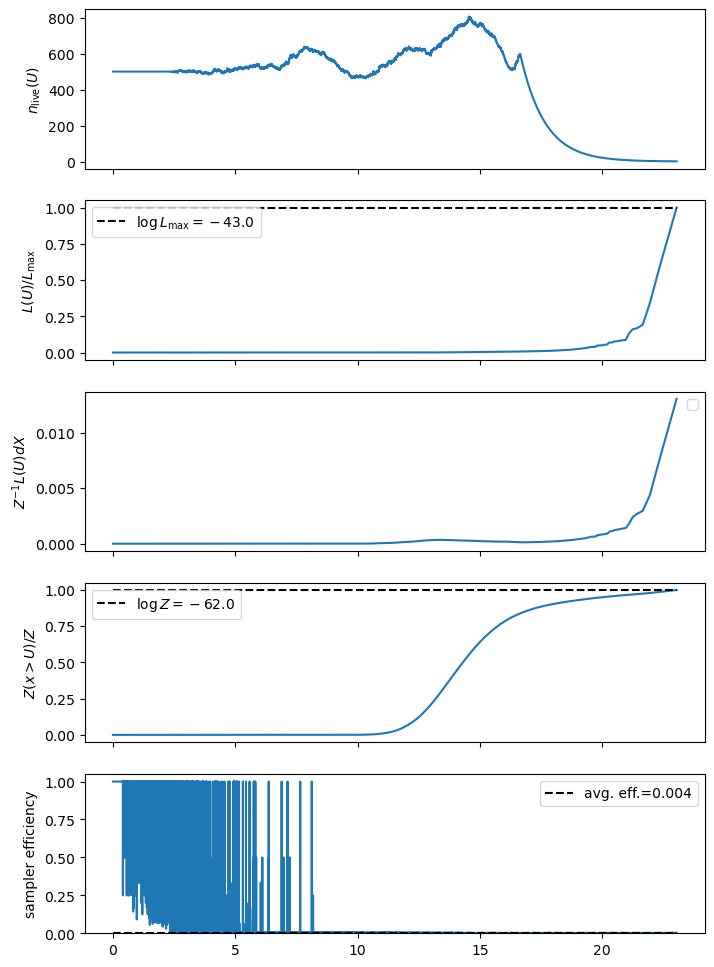

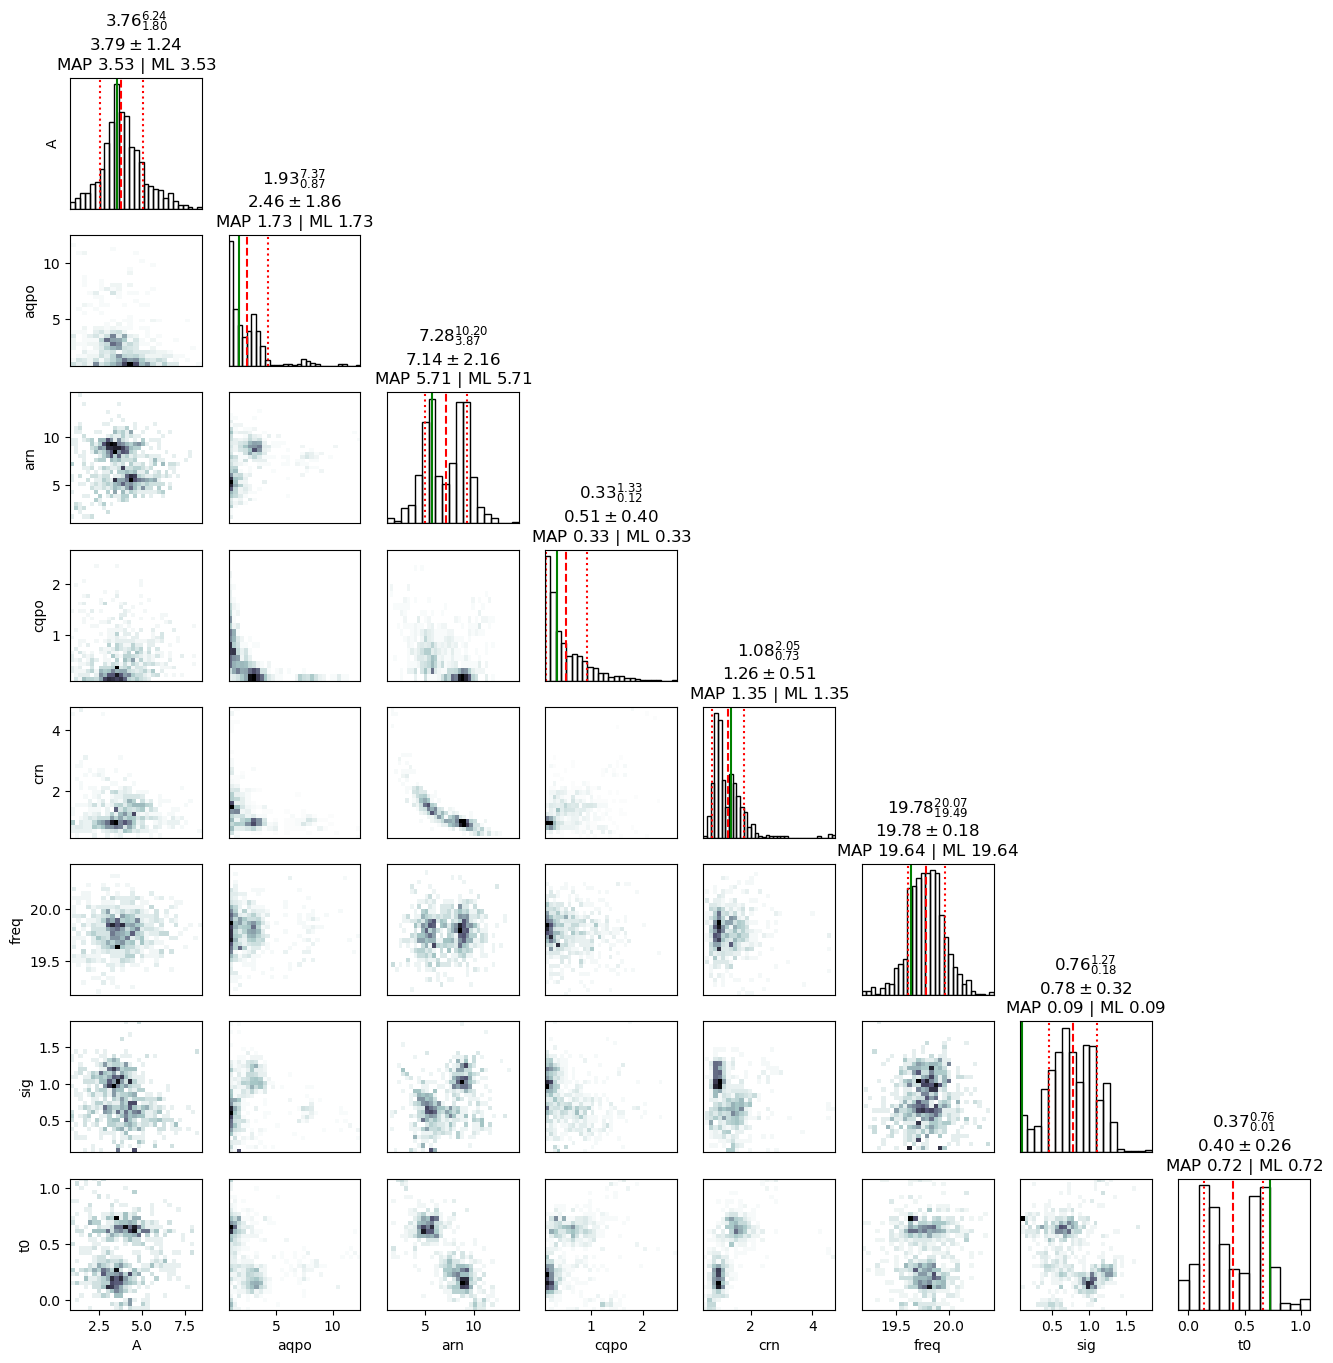

In [84]:
Results["QPOexact_ns"].plot_diagnostics(Results["QPOresults"])
Results["QPOexact_ns"].plot_cornerplot(Results["QPOresults"])

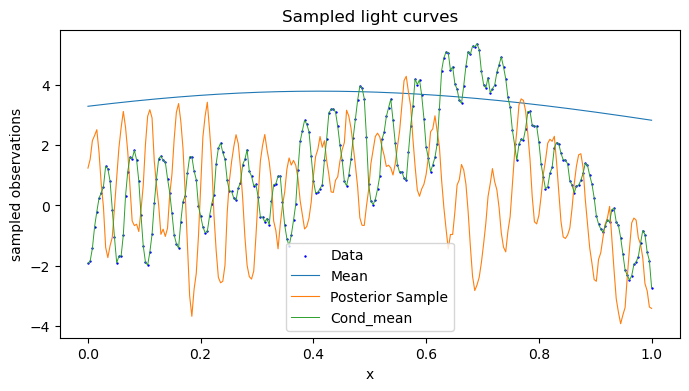

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(Times, lightcurve.T, lw=0.7, color = "b", label = "Data", s = 1)

post_qpoparams = {
    "arn": 7.1,    "crn": 1.27,
    "aqpo": 2.5,    "cqpo": 0.51,    "freq": 19.79
}
post_qpomeanparams = {
    "A": 3.8,    "t0": 0.41,    "sig": 0.77
}

gp = build_gp(post_qpoparams, post_qpomeanparams, Times, kernel_type = "QPO_plus_RN")
_ , cond_gp = gp.condition(lightcurve)
ax.plot(Times, gp.mean, lw=0.8, label = "Mean") 
ax.plot(Times, gp.sample(jax.random.PRNGKey(7)), lw=0.8, label = "Posterior Sample")
# When we are using the same key, then very similar samples are drawn
ax.plot(Times, cond_gp.mean, lw = 0.7, label = "Cond_mean")
# ax.plot(Times, RNresults.posterior_samples["mean"].T, lw=0.8, color = "r", label = "Mean")
ax.set_xlabel("x")
ax.set_ylabel("sampled observations")
ax.legend()
_ = plt.title("Sampled light curves")

In [97]:
BFrn, BFlqpo, BFhqpo = make_evidence_histogram(n = 5)

100%|██████████| 5/5 [14:19<00:00, 171.81s/it]
